In [12]:
from Bio import SeqIO, AlignIO
from Bio.Align.Applications import ClustalwCommandline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. FASTA 파일 경로 설정
fasta_files = [
    "denv1.fasta",
    "denv2.fasta",
    "denv3.fasta",
    "denv4.fasta"
]

In [13]:
# 2. FASTA 파일을 단일 파일로 병합
combined_fasta = "combined.fasta"
with open(combined_fasta, "w") as outfile:
    for fasta_file in fasta_files:
        with open(fasta_file) as infile:
            outfile.write(infile.read())
            outfile.write("\n")

# 3. ClustalW로 다중 서열 정렬
clustalw_exe = "C:\Program Files (x86)\ClustalW2\clustalw2.exe"  # ClustalW 실행 파일 경로 (시스템에 맞게 수정)
clustalw_cline = ClustalwCommandline(clustalw_exe, infile=combined_fasta, outfile="aligned.aln")
clustalw_cline()

# 4. 정렬된 서열 읽기
alignment = AlignIO.read("aligned.aln", "clustal")

<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:10: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Minjae\AppData\Local\Temp\ipykernel_680\764528321.py:10: SyntaxWarning: invalid escape sequence '\P'
  clustalw_exe = "C:\Program Files (x86)\ClustalW2\clustalw2.exe"  # ClustalW 실행 파일 경로 (시스템에 맞게 수정)


In [14]:
# 5. 공통 서열 식별 함수
def find_conserved_regions(alignment, min_length=10):
    conserved_regions = []
    seq_length = alignment.get_alignment_length()
    num_sequences = len(alignment)
    
    i = 0
    while i < seq_length:
        column = alignment[:, i]
        if len(set(column)) == 1 and column[0] != '-':
            start = i
            conserved_seq = column[0]
            j = i + 1
            while j < seq_length:
                next_column = alignment[:, j]
                if len(set(next_column)) == 1 and next_column[0] != '-':
                    conserved_seq += next_column[0]
                    j += 1
                else:
                    break
            if len(conserved_seq) >= min_length:
                conserved_regions.append({
                    "start": start + 1,
                    "end": j,
                    "sequence": conserved_seq,
                    "length": len(conserved_seq)
                })
            i = j
        else:
            i += 1
    
    return conserved_regions

# 6. 공통 서열 추출
conserved_regions = find_conserved_regions(alignment, min_length=10)

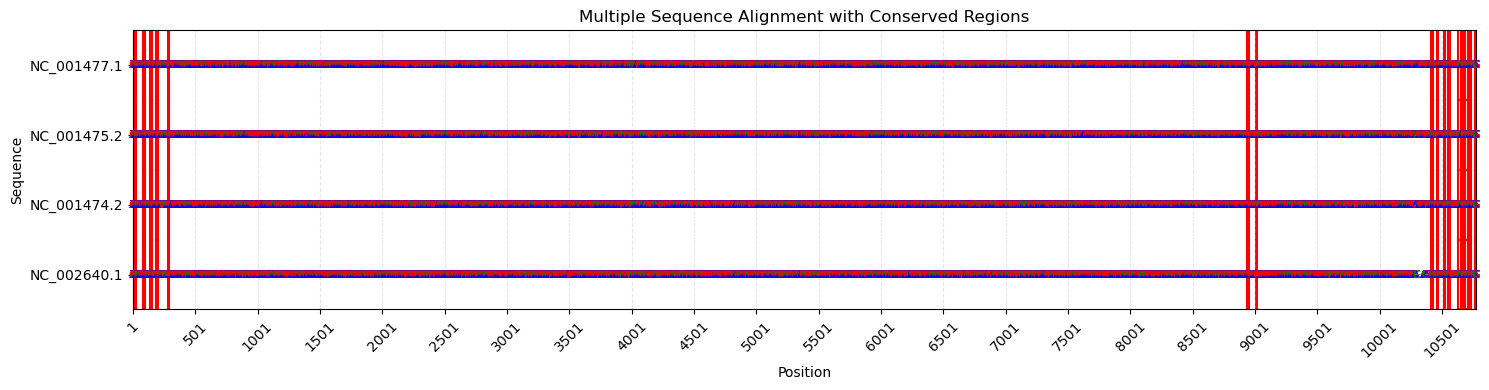

In [17]:
# 7. 시각화: 정렬된 서열과 공통 서열 표시
def visualize_alignment(alignment, conserved_regions, output_file="alignment_plot.png"):
    seq_length = alignment.get_alignment_length()
    num_sequences = len(alignment)
    
    # 서열 데이터를 문자로 변환
    seq_data = [str(record.seq) for record in alignment]
    seq_names = [record.id for record in alignment]
    
    # 아미노산/뉴클레오타이드별 색상 매핑 (단순화 예시)
    aa_colors = {
        'A': 'blue', 'C': 'green', 'G': 'red', 'T': 'purple', '-': 'gray',
        'D': 'orange', 'E': 'yellow', 'F': 'cyan', 'H': 'magenta',
        'I': 'lime', 'K': 'pink', 'L': 'teal', 'M': 'brown',
        'N': 'olive', 'P': 'navy', 'Q': 'coral', 'R': 'violet',
        'S': 'gold', 'V': 'indigo', 'W': 'salmon', 'Y': 'turquoise'
    }
    
    # 플롯 설정
    fig, ax = plt.subplots(figsize=(15, num_sequences * 0.5 + 2))
    
    # 서열 플롯
    for i, seq in enumerate(seq_data):
        for j, char in enumerate(seq):
            ax.text(j + 0.5, num_sequences - i - 0.5, char,
                    ha='center', va='center', color=aa_colors.get(char, 'black'),
                    fontsize=8)
    
    # 공통 서열 강조 (빨간색 박스로 표시)
    for region in conserved_regions:
        start = region['start'] - 1  # 0-based indexing
        end = region['end'] - 1
        length = end - start + 1
        for i in range(num_sequences):
            rect = plt.Rectangle((start, num_sequences - i - 1),
                                length, 1, fill=False, edgecolor='red', linewidth=1.5)
            ax.add_patch(rect)
    
    # 축 설정
    ax.set_xlim(0, seq_length)
    ax.set_ylim(0, num_sequences)
    ax.set_yticks(np.arange(num_sequences) + 0.5)
    ax.set_yticklabels(seq_names[::-1], fontsize=10)
    ax.set_xticks(np.arange(0, seq_length, 500))
    ax.set_xticklabels(np.arange(0, seq_length, 500) + 1, rotation=45)
    ax.set_xlabel("Position")
    ax.set_ylabel("Sequence")
    ax.set_title("Multiple Sequence Alignment with Conserved Regions")
    
    # 그리드 추가
    ax.grid(True, which='both', linestyle='--', alpha=0.3)
    
    # 레이아웃 조정 및 저장
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

# 8. 시각화 실행
visualize_alignment(alignment, conserved_regions, output_file="alignment_plot.png")


In [16]:
# 9. 결과 출력
if conserved_regions:
    print("Found conserved regions:")
    df = pd.DataFrame(conserved_regions)
    print(df[["start", "end", "length", "sequence"]])
    df.to_csv("conserved_regions.csv", index=False)
else:
    print("No conserved regions found with the specified minimum length.")

# 10. 정리: 임시 파일 삭제
# os.remove(combined_fasta)
# os.remove("aligned.aln")
# os.remove("combined.dnd")

Found conserved regions:
    start    end  length                      sequence
0       1     12      12                  AGTTGTTAGTCT
1      15     26      12                  GTGGACCGACAA
2      81     97      17             TAGAGAGCAGATCTCTG
3     137    154      18            TCAATATGCTGAAACGCG
4     190    201      12                  AAGAGATTCTCA
5     280    290      11                   CCAACAGCAGG
6    8939   8949      11                   AACATGATGGG
7    9005   9016      12                  TGGTACATGTGG
8   10413  10423      11                   GAAGTCAGGCC
9   10457  10468      12                  GCCTGTAGCTCC
10  10515  10527      13                 GGAAGCTGTACGC
11  10546  10565      20          GGTTAGAGGAGACCCCTCCC
12  10627  10654      28  AAGGACTAGAGGTTAGAGGAGACCCCCC
13  10665  10686      22        AAACAGCATATTGACGCTGGGA
14  10688  10709      22        AGACCAGAGATCCTGCTGTCTC
15  10721  10732      12                  TCCAGGCACAGA
16  10763  10773      11                